In [19]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Load the dataset from Kaggle

In [20]:
# Download Dataset from Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kavyasreeb/hair-type-dataset

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kavyasreeb/hair-type-dataset
License(s): apache-2.0
hair-type-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [21]:
# Extract Dataset
with zipfile.ZipFile("hair-type-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("HairDataset")



In [22]:
# Define dataset path
dataset_path = "/content/HairDataset/data"

# EDA

<ipython-input-23-d03978e27767>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="viridis")


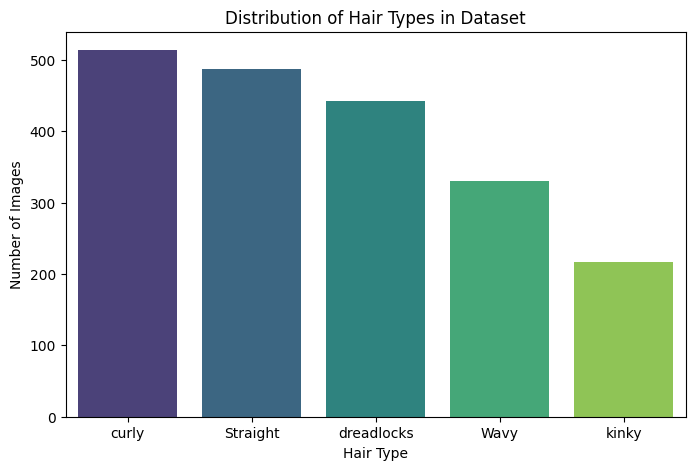

In [23]:
# Count images per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Convert to DataFrame for easy visualization
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df = df.sort_values(by="Count", ascending=False)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.barplot(x="Class", y="Count", data=df, palette="viridis")
plt.title("Distribution of Hair Types in Dataset")
plt.xlabel("Hair Type")
plt.ylabel("Number of Images")
plt.show()

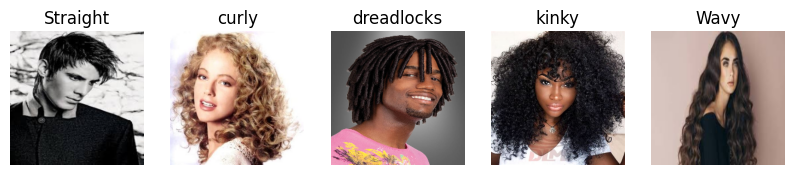

In [ ]:
# Display sample images
plt.figure(figsize=(10, 5))
for i, category in enumerate(categories[:5]):
    img_path = os.path.join(data_dir, category, os.listdir(os.path.join(data_dir, category))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.show()

In [24]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for img in os.listdir(class_dir):
            data.append({"filename": os.path.join(class_name, img), "Class": class_name})
df = pd.DataFrame(data)

In [25]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Class"], random_state=42)

# Data Augmentation

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=dataset_path,
    x_col="filename",
    y_col="Class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=dataset_path,
    x_col="filename",
    y_col="Class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

Found 1590 validated image filenames belonging to 5 classes.
Found 397 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [28]:
# Extract class labels
y_train = train_generator.classes  # Get labels for training set
class_labels = list(train_generator.class_indices.keys())

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Class Indices:", train_generator.class_indices)
print("Class Weights:", class_weight_dict)

Class Indices: {'Straight': 0, 'Wavy': 1, 'curly': 2, 'dreadlocks': 3, 'kinky': 4}
Class Weights: {0: 0.8174807197943444, 1: 1.209125475285171, 2: 0.775609756097561, 3: 0.8983050847457628, 4: 1.8275862068965518}


# Modeling

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models


def build_advanced_densenet(input_shape=(224, 224, 3), num_classes=5):
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze DenseNet layers initially

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(224, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the corrected DenseNet model
model = build_advanced_densenet()
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 224)                 │         229,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          28,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,296,549 (27.83 MB)

 Trainable params: 259,045 (1011.89 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True, verbose=1
)

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,  # Adjust decay step size for smoother transitions
    alpha=0.00001
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_advanced_densenet.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Train the Model (First Phase: Frozen Base)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.2773 - loss: 1.6607

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.32244, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.2778 - loss: 1.6589 - val_accuracy: 0.5542 - val_loss: 1.3224
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4687 - loss: 1.3171
Epoch 2: val_loss improved from 1.32244 to 1.12360, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 490ms/step - accuracy: 0.4689 - loss: 1.3162 - val_accuracy: 0.6222 - val_loss: 1.1236
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5723 - loss: 1.1131
Epoch 3: val_loss improved from 1.12360 to 0.97606, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 493ms/step - accuracy: 0.5726 - loss: 1.1125 - val_accuracy: 0.6952 - val_loss: 0.9761
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.6553 - loss: 0.9459
Epoch 4: val_loss improved from 0.97606 to 0.85520, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 486ms/step - accuracy: 0.6550 - loss: 0.9461 - val_accuracy: 0.7179 - val_loss: 0.8552
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6924 - loss: 0.8282
Epoch 5: val_loss improved from 0.85520 to 0.76741, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 486ms/step - accuracy: 0.6921 - loss: 0.8284 - val_accuracy: 0.7531 - val_loss: 0.7674
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7021 - loss: 0.7640
Epoch 6: val_loss improved from 0.76741 to 0.70683, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.7022 - loss: 0.7637 - val_accuracy: 0.7632 - val_loss: 0.7068
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7310 - loss: 0.7004
Epoch 7: val_loss improved from 0.70683 to 0.66667, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 496ms/step - accuracy: 0.7312 - loss: 0.7001 - val_accuracy: 0.7657 - val_loss: 0.6667
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7745 - loss: 0.6134
Epoch 8: val_loss improved from 0.66667 to 0.61484, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 489ms/step - accuracy: 0.7738 - loss: 0.6142 - val_accuracy: 0.7758 - val_loss: 0.6148
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7888 - loss: 0.6092
Epoch 9: val_loss improved from 0.61484 to 0.59330, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.7886 - loss: 0.6092 - val_accuracy: 0.7935 - val_loss: 0.5933
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7750 - loss: 0.5862
Epoch 10: val_loss did not improve from 0.59330
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 469ms/step - accuracy: 0.7751 - loss: 0.5862 - val_accuracy: 0.7859 - val_loss: 0.6080
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7982 - loss: 0.5580
Epoch 11: val_loss did not improve from 0.59330
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 475ms/step - accuracy: 0.7980 - loss: 0.5579 - val_accuracy: 0.7607 - val_loss: 0.5982
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7869 - loss: 0.5544
Epoch 12: val_loss improved from 0.59330 to 0.54789, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.7870 - loss: 0.5541 - val_accuracy: 0.8035 - val_loss: 0.5479
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7952 - loss: 0.5309
Epoch 13: val_loss improved from 0.54789 to 0.53873, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 486ms/step - accuracy: 0.7952 - loss: 0.5307 - val_accuracy: 0.8060 - val_loss: 0.5387
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8235 - loss: 0.4902
Epoch 14: val_loss did not improve from 0.53873
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.8232 - loss: 0.4903 - val_accuracy: 0.8010 - val_loss: 0.5492
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8298 - loss: 0.4623
Epoch 15: val_loss improved from 0.53873 to 0.53230, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 486ms/step - accuracy: 0.8297 - loss: 0.4623 - val_accuracy: 0.8035 - val_loss: 0.5323
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8563 - loss: 0.4232
Epoch 16: val_loss improved from 0.53230 to 0.51368, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 487ms/step - accuracy: 0.8560 - loss: 0.4239 - val_accuracy: 0.8161 - val_loss: 0.5137
Epoch 17/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8485 - loss: 0.4070
Epoch 17: val_loss improved from 0.51368 to 0.50331, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.8484 - loss: 0.4074 - val_accuracy: 0.8186 - val_loss: 0.5033
Epoch 18/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8526 - loss: 0.4081
Epoch 18: val_loss did not improve from 0.50331
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 474ms/step - accuracy: 0.8525 - loss: 0.4082 - val_accuracy: 0.7935 - val_loss: 0.5439
Epoch 19/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8565 - loss: 0.3933
Epoch 19: val_loss did not improve from 0.50331
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 472ms/step - accuracy: 0.8561 - loss: 0.3940 - val_accuracy: 0.7960 - val_loss: 0.5463
Epoch 20/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8574 - loss: 0.3752
Epoch 20: val_loss improved from 0.50331 to 0.48579, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 493ms/step - accuracy: 0.8571 - loss: 0.3759 - val_accuracy: 0.8237 - val_loss: 0.4858
Epoch 21/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8564 - loss: 0.3866
Epoch 21: val_loss did not improve from 0.48579
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 478ms/step - accuracy: 0.8563 - loss: 0.3867 - val_accuracy: 0.8136 - val_loss: 0.5152
Epoch 22/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8629 - loss: 0.3607
Epoch 22: val_loss did not improve from 0.48579
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.8627 - loss: 0.3609 - val_accuracy: 0.8111 - val_loss: 0.5011
Epoch 23/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8601 - loss: 0.3649
Epoch 23: val_loss improved from 0.48579 to 0.47606, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.8602 - loss: 0.3647 - val_accuracy: 0.8212 - val_loss: 0.4761
Epoch 24/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8620 - loss: 0.3601
Epoch 24: val_loss did not improve from 0.47606
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.8622 - loss: 0.3598 - val_accuracy: 0.8161 - val_loss: 0.4879
Epoch 25/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8661 - loss: 0.3682
Epoch 25: val_loss did not improve from 0.47606
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - accuracy: 0.8663 - loss: 0.3678 - val_accuracy: 0.8237 - val_loss: 0.4887
Epoch 26/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8700 - loss: 0.3691
Epoch 26: val_loss did not improve from 0.47606
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 470ms/step - accuracy: 0.8700 - loss: 0.3690 - val_accuracy: 0.8237 - val_loss: 0.4774
Epoch 27/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8656 - loss: 0.3523
Epoch 27: val_loss did not impro

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.8706 - loss: 0.3383 - val_accuracy: 0.8438 - val_loss: 0.4496
Epoch 29/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8829 - loss: 0.3005
Epoch 29: val_loss did not improve from 0.44965
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 472ms/step - accuracy: 0.8828 - loss: 0.3009 - val_accuracy: 0.8262 - val_loss: 0.4829
Epoch 30/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8820 - loss: 0.2988
Epoch 30: val_loss did not improve from 0.44965
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.8820 - loss: 0.2987 - val_accuracy: 0.8312 - val_loss: 0.4567
Epoch 31/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8894 - loss: 0.3162
Epoch 31: val_loss did not improve from 0.44965
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.8894 - loss: 0.3161 - val_accuracy: 0.8262 - val_loss: 0.4778
Epoch 32/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9115 - loss: 0.2523
Epoch 32: val_loss did not impro

In [36]:
base_model = model.layers[0]  # DenseNet121 model
# Unfreeze last 100 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

# Lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,  # Fine-tune longer
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.8108 - loss: 0.5136
Epoch 1: val_loss did not improve from 0.44965
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8113 - loss: 0.5123 - val_accuracy: 0.8262 - val_loss: 0.4512
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8756 - loss: 0.3426
Epoch 2: val_loss improved from 0.44965 to 0.42467, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 494ms/step - accuracy: 0.8753 - loss: 0.3430 - val_accuracy: 0.8438 - val_loss: 0.4247
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8883 - loss: 0.3090
Epoch 3: val_loss improved from 0.42467 to 0.39713, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.8882 - loss: 0.3092 - val_accuracy: 0.8363 - val_loss: 0.3971
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8665 - loss: 0.3313
Epoch 4: val_loss improved from 0.39713 to 0.38776, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.8668 - loss: 0.3308 - val_accuracy: 0.8539 - val_loss: 0.3878
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8966 - loss: 0.2885
Epoch 5: val_loss improved from 0.38776 to 0.37360, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.8965 - loss: 0.2887 - val_accuracy: 0.8589 - val_loss: 0.3736
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8991 - loss: 0.2586
Epoch 6: val_loss did not improve from 0.37360
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.8992 - loss: 0.2584 - val_accuracy: 0.8589 - val_loss: 0.3778
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9087 - loss: 0.2345
Epoch 7: val_loss improved from 0.37360 to 0.36688, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 487ms/step - accuracy: 0.9087 - loss: 0.2345 - val_accuracy: 0.8615 - val_loss: 0.3669
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9052 - loss: 0.2133
Epoch 8: val_loss improved from 0.36688 to 0.36420, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 487ms/step - accuracy: 0.9054 - loss: 0.2132 - val_accuracy: 0.8640 - val_loss: 0.3642
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9299 - loss: 0.1946
Epoch 9: val_loss improved from 0.36420 to 0.36247, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.9299 - loss: 0.1945 - val_accuracy: 0.8665 - val_loss: 0.3625
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9317 - loss: 0.1841
Epoch 10: val_loss improved from 0.36247 to 0.35880, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.9318 - loss: 0.1840 - val_accuracy: 0.8640 - val_loss: 0.3588
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9355 - loss: 0.1918
Epoch 11: val_loss improved from 0.35880 to 0.35340, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.9356 - loss: 0.1914 - val_accuracy: 0.8640 - val_loss: 0.3534
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9509 - loss: 0.1425
Epoch 12: val_loss did not improve from 0.35340
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - accuracy: 0.9509 - loss: 0.1427 - val_accuracy: 0.8615 - val_loss: 0.3558
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9373 - loss: 0.1541
Epoch 13: val_loss did not improve from 0.35340
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - accuracy: 0.9374 - loss: 0.1541 - val_accuracy: 0.8640 - val_loss: 0.3557
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9520 - loss: 0.1466
Epoch 14: val_loss did not improve from 0.35340
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 472ms/step - accuracy: 0.9520 - loss: 0.1466 - val_accuracy: 0.8690 - val_loss: 0.3563
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9517 - loss: 0.1386
Epoch 15: val_loss improved from 0.3

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 493ms/step - accuracy: 0.9516 - loss: 0.1388 - val_accuracy: 0.8665 - val_loss: 0.3478
Epoch 16/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9474 - loss: 0.1524
Epoch 16: val_loss did not improve from 0.34779
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 472ms/step - accuracy: 0.9475 - loss: 0.1522 - val_accuracy: 0.8690 - val_loss: 0.3483
Epoch 17/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9568 - loss: 0.1333
Epoch 17: val_loss did not improve from 0.34779
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 474ms/step - accuracy: 0.9569 - loss: 0.1331 - val_accuracy: 0.8539 - val_loss: 0.3580
Epoch 18/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9644 - loss: 0.1041
Epoch 18: val_loss improved from 0.34779 to 0.34458, saving model to best_advanced_densenet.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.9644 - loss: 0.1042 - val_accuracy: 0.8690 - val_loss: 0.3446
Epoch 19/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9644 - loss: 0.1139
Epoch 19: val_loss did not improve from 0.34458
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 472ms/step - accuracy: 0.9643 - loss: 0.1140 - val_accuracy: 0.8640 - val_loss: 0.3564
Epoch 20/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9623 - loss: 0.1123
Epoch 20: val_loss did not improve from 0.34458
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 474ms/step - accuracy: 0.9624 - loss: 0.1121 - val_accuracy: 0.8715 - val_loss: 0.3504
Epoch 21/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9733 - loss: 0.0891
Epoch 21: val_loss did not improve from 0.34458
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - accuracy: 0.9731 - loss: 0.0894 - val_accuracy: 0.8690 - val_loss: 0.3489
Epoch 22/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9848 - loss: 0.0685
Epoch 22: val_loss did not improve f

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 489ms/step - accuracy: 0.9733 - loss: 0.0865 - val_accuracy: 0.8766 - val_loss: 0.3392
Epoch 24/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9717 - loss: 0.1002
Epoch 24: val_loss did not improve from 0.33920
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 472ms/step - accuracy: 0.9718 - loss: 0.0998 - val_accuracy: 0.8715 - val_loss: 0.3441
Epoch 25/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9864 - loss: 0.0598
Epoch 25: val_loss did not improve from 0.33920
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.9863 - loss: 0.0602 - val_accuracy: 0.8715 - val_loss: 0.3521
Epoch 26/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9749 - loss: 0.0729
Epoch 26: val_loss did not improve from 0.33920
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.9749 - loss: 0.0729 - val_accuracy: 0.8640 - val_loss: 0.3569
Epoch 27/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9723 - loss: 0.0805
Epoch 27: val_loss did not improve f

In [38]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8761 - loss: 0.3351
Test Accuracy: 0.8766, Test Loss: 0.3392


13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

Classification Report:
              precision    recall  f1-score   support

    Straight       0.86      0.86      0.86        96
        Wavy       0.79      0.83      0.81        66
       curly       0.91      0.88      0.90       103
  dreadlocks       0.92      0.94      0.93        89
       kinky       0.90      0.81      0.85        43

    accuracy                           0.88       397
   macro avg       0.87      0.87      0.87       397
weighted avg       0.88      0.88      0.88       397



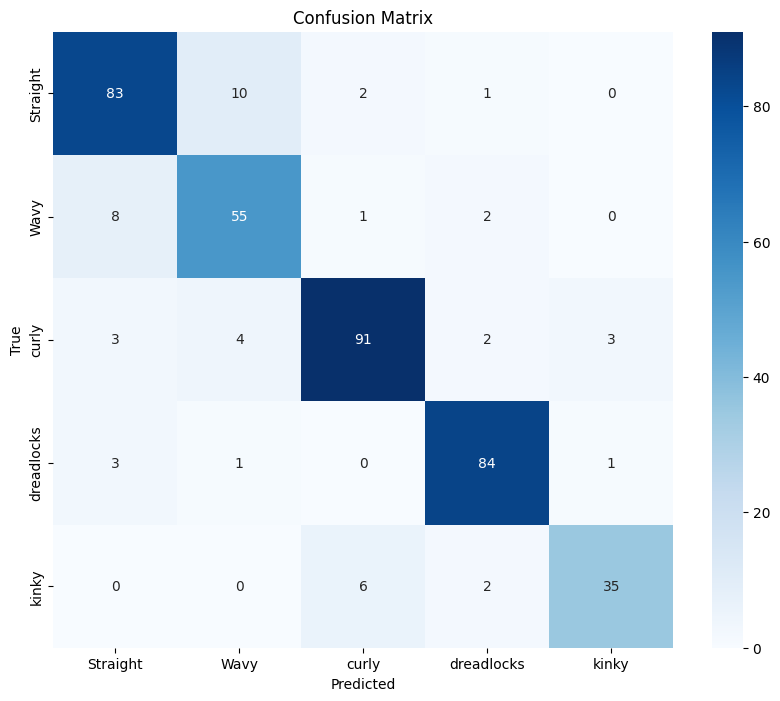

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions on test set
test_generator.reset()  # Reset generator to start from the beginning
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

# Get true classes from test generator
true_classes = test_generator.classes  # Ground truth labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

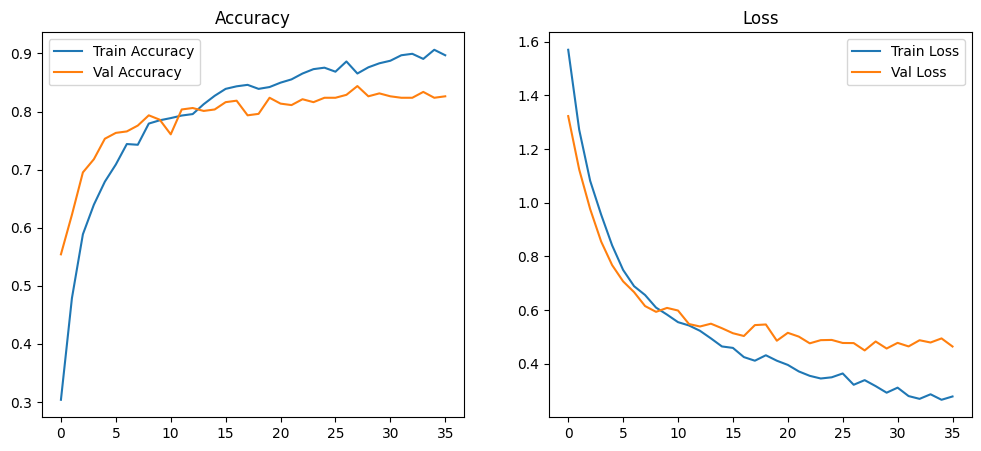

In [40]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [41]:
model.save("advanced_densenet_model.h5")